In [2]:
import twitter

In [892]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
from datetime import datetime,date
from dateutil import parser
import seaborn as sns
import pandas as pd
import numpy as np
import collections
import re
from scipy import stats
import random

In [ ]:
#april 2016 - en marche founded
#aug 2016 - macron resigns
#November 2016 - announces his candidature

In [4]:
api=twitter.Api(consumer_key='6UY8gr81H36FZTI1n0auHvc3G',
               consumer_secret='cQ2ntFofhJ7VD8Ve0DzDPiecNnvoNoSjoyAOh1GJgiGxZPtN17',
               access_token_key='810095535935864832-XtxAJTnRCFgV3s0I6tXs6Y4QS3HSOrq',
               access_token_secret='0w3G3ULXlKBtkggiBRDPh7FUNsE48Zt9cKnyb5Ag2Df8T')

In [ ]:
random.seed()

In [1790]:
color_pink='#F19B80'
color_orange='#EE5E38'
color_blue='#6AD0F6'
color_deep_blue='#159DCE'
color_dark_teal='#00526D'
color_red='#EE261D'
palette=[color_deep_blue,color_orange,color_dark_teal,color_blue,color_pink]

In [985]:
def get_timeline(screen_name,n_pages=10):
    status=api.GetUserTimeline(screen_name=screen_name,count=200)
    max_id=status[-1].id
    for _ in range(n_pages):    
        status_tmp=api.GetUserTimeline(screen_name=screen_name,count=200,max_id=max_id)
        max_id=status_tmp[-1].id
        status.extend(status_tmp) 
    df=pd.DataFrame([x.AsDict() for x in status])
    df.created_at=pd.to_datetime(df.created_at)
    df['date']=[x.date() for x in df.created_at]
    df['hour']=[x.hour for x in df.created_at]
    df=df.set_index('id')
    print("Fetched {} tweets of {}, from {} to {}".format(df.shape[0],screen_name,
                                                          df['date'].iloc[-1],df['date'].iloc[0]))
    return(df)

## Load the data

#### Le Pen

In [986]:
df_lp=get_timeline('MLP_officiel',n_pages=20)
df_lp_nort=df_lp[pd.isnull(df_lp.retweeted_status)]

Fetched 3237 tweets of MLP_officiel, from 2015-12-10 to 2017-03-08


In [965]:
df_lp.to_csv("lepen.csv",encoding='utf-8')

In [8]:
start_date=df_lp.created_at.iloc[-1]

#### Macron

In [987]:
df_full=get_timeline('EmmanuelMacron',n_pages=20)
df=df_full[df_full.created_at>=start_date]
df_nort=df[pd.isnull(df.retweeted_status)]
df_full_nort=df_full[pd.isnull(df_full.retweeted_status)]

Fetched 2094 tweets of EmmanuelMacron, from 2014-08-29 to 2017-03-08


In [ ]:
df_full.to_csv("macron.csv",encoding='utf-8')

In [1928]:
def to_coord(stamp,x_min,x_max,stamp_min,stamp_max):
    return x_min+(x_max-x_min)*(stamp.toordinal()-stamp_min.toordinal())/(stamp_max.toordinal()-stamp_min.toordinal())
def vline(ax,mn,mx,height,date,text,color='red',alignment='right'):
    xlm=ax.get_xlim()
    crd=to_coord(pd.Timestamp(date, freq='20D'),
                                   xlm[0],
                                   xlm[1],
                                   mn,
                                   mx
                                  )
    ax.axvline(crd,ymin=0,ymax=height,color=color,linestyle='dashed',linewidth=0.5)
    ax.text(crd,ax.get_ylim()[1]*height,text.upper(),color=color,weight='ultralight',
            style='oblique',horizontalalignment=alignment,fontsize='small')
def plot_tweets(dfs):
    col=palette
    i=0
    axx={}

    min_date=[]
    max_date=[]
    
    for name in dfs.keys():
        df1=dfs[name]
        agg=df1.groupby('date')['retweet_count'].count()
        agg.index=pd.DatetimeIndex(agg.index)
        resampled=agg.resample('20D',label='right').mean()
        
        min_date.append(resampled.index[0])
        max_date.append(resampled.index[-1])
        axx[name]=resampled.plot.line(color=col[i%len(col)])
        axx[name].set_axis_bgcolor('w')
        axx[name].yaxis.grid(color='lightgray')
        axx[name].xaxis.grid(False)
        axx[name].set_xlabel('')        
        fig=axx[name].figure
    
        i+=1
        
    #vline(axx[name],min(min_date),max(max_date),0.6,'2016-10-8 00:00:00','Police attacked at Viry-Chatillon',color_red)
    #vline(axx[name],min(min_date),max(max_date),0.7,'2016-3-22 00:00:00','Attacks at Bruxels',color_red)
    #vline(axx[name],min(min_date),max(max_date),0.8,'2016-3-27 00:00:00','Easter',color_red)
    #vline(axx[name],min(min_date),max(max_date),0.8,'2016-5-4 00:00:00','Luigi',color_red)
    #vline(axx[name],min(min_date),max(max_date),0.9,'2016-5-13 00:00:00','Verdun',color_red)
    #vline(axx[name],min(min_date),max(max_date),0.9,'2016-11-8 00:00:00','US elections',color_red) 
    #vline(axx[name],min(min_date),max(max_date),0.7,'2016-6-23 00:00:00','Brexit vote',color_red,alignment='left')
    
    plt.axhline(0,color='grey')
    plt.tick_params(axis='x',color='grey',top='off',width=1,length=5)
    legend=plt.legend(axx.keys(),fancybox=True,frameon=True,loc=(0.8,0.85))
    legend.get_frame().set_color('w')
    plt.show()
    fig.savefig("tweets",bbox_inches='tight')
    
def plot_favorite(dfs):
    col=palette
    i=0
    axx={}
    min_date=[]
    max_date=[]
    for name in dfs.keys():
        df1=dfs[name]
        agg=df1.groupby('date')['favorite_count'].aggregate(np.max)
        agg.index=pd.DatetimeIndex(agg.index)
        
        resampled=agg.resample('20D',label='right').mean()
        axx[name]=resampled.plot(x='created_at',y='favorite_count',color=col[i%len(col)])
        axx[name].set_axis_bgcolor('w')
        axx[name].yaxis.grid(color='lightgray')
        axx[name].xaxis.grid(False)
        axx[name].set_xlabel('')
        fig=axx[name].figure
        min_date.append(resampled.index[0])
        max_date.append(resampled.index[-1])
    
        
        i+=1  
    vline(axx[name],min(min_date),max(max_date),0.61,'2016-6-23 00:00:00','Brexit vote',color_red)
    vline(axx[name],min(min_date),max(max_date),0.71,'2016-7-14 00:00:00','Attack at Nice',color_red)
    vline(axx[name],min(min_date),max(max_date),0.81,'2016-7-26 00:00:00',u'Attack at Saint-Étienne-du-Rouvray',color_red)
    vline(axx[name],min(min_date),max(max_date),0.91,'2016-11-8 00:00:00','US elections',color_red)
    plt.axhline(0,color='grey')
    plt.tick_params(axis='x',color='grey',top='off',width=1,length=5)
    legend=plt.legend(axx.keys(),fancybox=True,frameon=True,loc=(0.8,0.05))
    legend.get_frame().set_color('w')
    plt.show()
    fig.savefig("favorites",bbox_inches='tight')
    
def plot_retweets(dfs):
    col=palette
    i=0
    axx={}
    min_date=[]
    max_date=[]
    for name in dfs.keys():
        df1=dfs[name]
        agg=df1.groupby('date')['retweet_count'].aggregate(np.mean)
        agg.index=pd.DatetimeIndex(agg.index)
        resampled=agg.resample('20D',label='right').mean()
        
        min_date.append(resampled.index[0])
        max_date.append(resampled.index[-1])
        
        axx[name]=resampled.plot.line(x='created_at',y='retweet_count',color=col[i%len(col)])
        axx[name].set_axis_bgcolor('w')
        axx[name].yaxis.grid(color='lightgray')
        axx[name].xaxis.grid(False)
        axx[name].set_xlabel('')
        fig=axx[name].figure
        i+=1
        
    vline(axx[name],min(min_date),max(max_date),0.605,'2016-6-23 00:00:00','Brexit vote',color_red)
    vline(axx[name],min(min_date),max(max_date),0.705,'2016-7-14 00:00:00','Attack at Nice',color_red)
    vline(axx[name],min(min_date),max(max_date),0.805,'2016-7-26 00:00:00',u'Attack at Saint-Étienne-du-Rouvray',color_red)
    vline(axx[name],min(min_date),max(max_date),0.905,'2016-11-8 00:00:00','US elections',color_red)
    
    plt.axhline(0,color='grey')
    plt.tick_params(axis='x',color='grey',top='off',width=1,length=5)
    legend=plt.legend(axx.keys(),fancybox=True,frameon=True,loc=(0.8,0.831))
    legend.get_frame().set_color('w')
    plt.show()
    
    fig.savefig("retweets",bbox_inches='tight')

In [1921]:
df1=df
df1=df1[~df1['favorite_count'].isnull()]
df1.sort('favorite_count',ascending=False);

/Users/grisha.oryol/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


## Average number of tweets, likes and retweets 

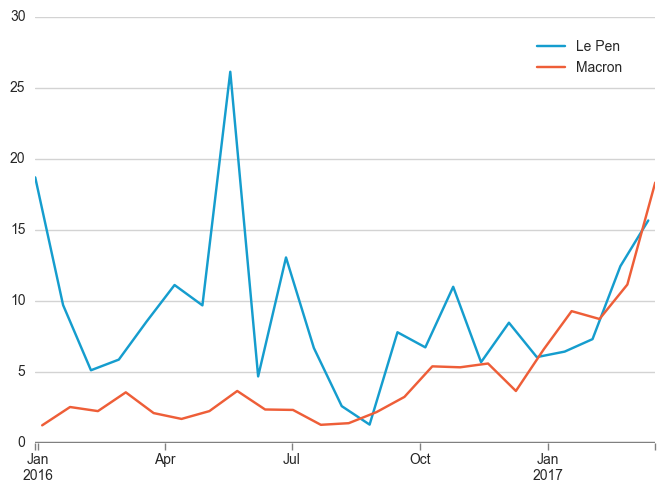

In [1903]:
plot_tweets({"Macron":df_nort,"Le Pen":df_lp_nort})

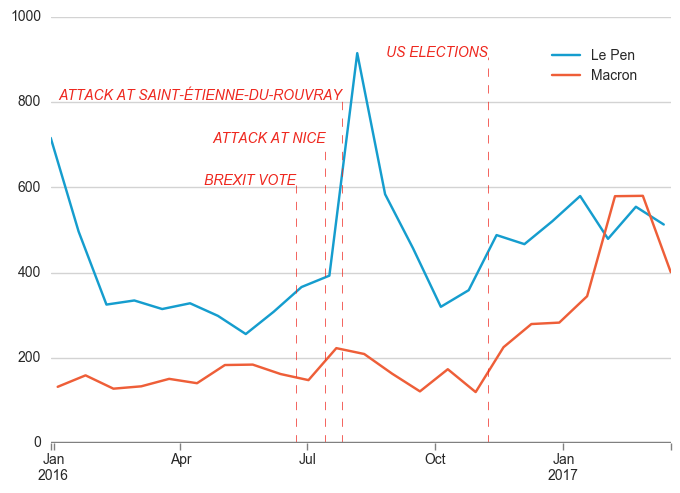

In [1926]:
plot_retweets({'Macron':df_nort,'Le Pen':df_lp_nort})

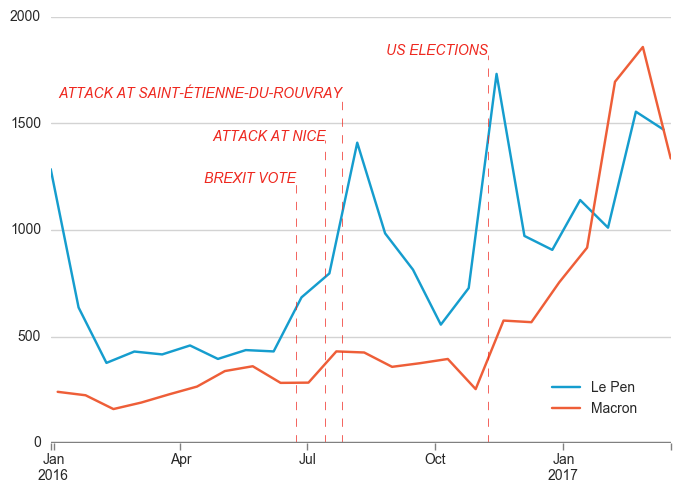

In [1929]:
plot_favorite({'Macron':df_nort,'Le Pen':df_lp_nort})

In [94]:
df_lp_nort[(df_lp_nort['favorite_count']==df_lp_nort[df_lp_nort['date']<date(2016, 11, 1)]['favorite_count'].max())].text

id
760750551143505920    Et si l'on faisait des parkings sur l'emplacem...
Name: text, dtype: object

## Basic stats

In [394]:
print(df_nort.favorite_count.mean(),
      df_lp_nort.favorite_count.mean(),
       df_ff_nort.favorite_count.mean())

(370.8743842364532, 369.43865328585304, 370.31857142857143)


In [395]:
print(df_nort.retweet_count.mean(),
      df_lp_nort.retweet_count.mean(),
       df_ff_nort.retweet_count.mean())

(256.32512315270935, 280.5865976044027, 317.64642857142854)


In [486]:
print(df_nort.groupby('date').count()['created_at'].mean(),
      df_lp_nort.groupby('date').count()['created_at'].mean(),
      df_ff_nort.groupby('date').count()['created_at'].mean()
     )

(5.058091286307054, 9.504615384615384, 10.37037037037037)


In [ ]:
df_nort.groupby('date').count()['created_at'].mean()

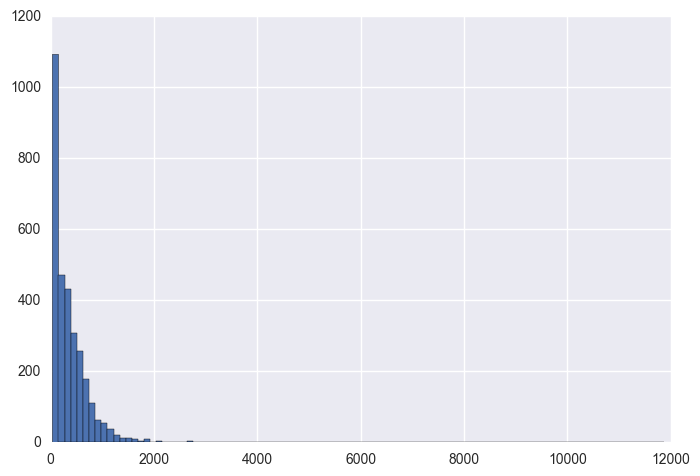

In [391]:
df_lp_nort['favorite_count'].hist(bins=100)
plt.show()

## Favorites vs retweets

0.712991926879


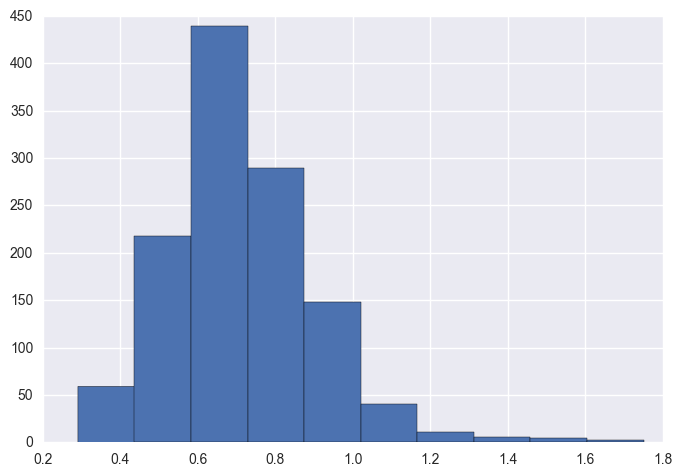

In [398]:
fav_to_rt=df_nort['retweet_count']/df_nort['favorite_count']
print(fav_to_rt.mean())
fav_to_rt.hist(bins=10)
plt.show()

0.867056588961


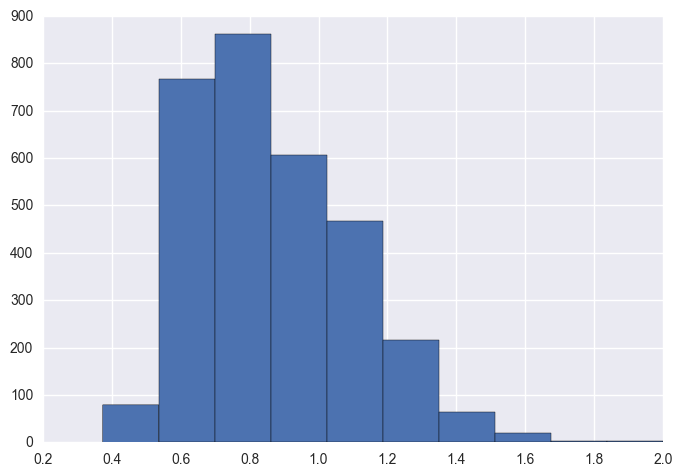

In [397]:
fav_to_rt=df_lp_nort['retweet_count']/df_lp_nort['favorite_count']
print(fav_to_rt.mean())
fav_to_rt.hist(bins=10)
plt.show()

0.95998870815


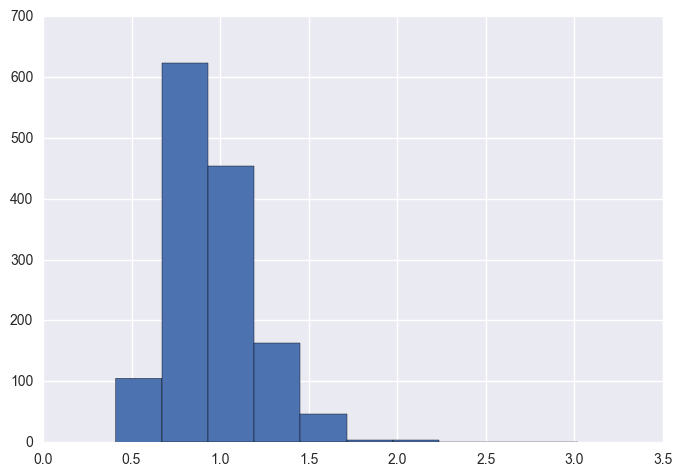

In [396]:
fav_to_rt=df_ff_nort['retweet_count']/df_ff_nort['favorite_count']
print(fav_to_rt.mean())
fav_to_rt.hist(bins=10)
plt.show()

## Punctuation

In [443]:
def check_punctuation(df_nort):
    print(np.mean(df_nort[['favorite_count','retweet_count']]))   
    for c in u"!?…"[:2]:
        print("------")
        print(len([x for i,x in df_nort.iterrows() if c in x.text])/float(len(df_nort.text)))
        print(np.mean(pd.DataFrame([x for i,x in df_nort.iterrows() if c in x.text])[['favorite_count','retweet_count']])/np.mean(df_nort[['favorite_count','retweet_count']]))

In [444]:
check_punctuation(df_full_nort)

favorite_count    265.605649
retweet_count     201.287344
dtype: float64
------
0.148288973384
favorite_count    0.869173
retweet_count     0.832717
dtype: float64
------
0.0097772949484
favorite_count    0.620803
retweet_count     0.624315
dtype: float64


In [445]:
check_punctuation(df_lp_nort)

favorite_count    369.438653
retweet_count     280.586598
dtype: float64
------
0.161864681127
favorite_count    1.434317
retweet_count     1.493143
dtype: float64
------
0.0301068306895
favorite_count    1.042907
retweet_count     1.134566
dtype: float64


In [446]:
check_punctuation(df_ff_nort)

favorite_count    370.318571
retweet_count     317.646429
dtype: float64
------
0.113571428571
favorite_count    0.918128
retweet_count     0.914707
dtype: float64
------
0.0221428571429
favorite_count    1.297227
retweet_count     1.365994
dtype: float64


## Words

In [932]:
particles_lp=[u'de', u'', u'la', u'l', u'\xe0', u'les', u'le', u'et', u'des', u'en', u'd', u'est', u'je', u'du', 
 u'pour', u'une', u'nous', u'un', u'qui', u'que', u'dans', u'a', u'ce', u'au', u'sur', u'pas', u'il',
 u'notre', u'ne', u'avec', u'nos', u'n', u'aux',u'par', u'c', u'ont', u'j',
 u'plus',  u'mon', u'rt', u'se', u'on', u'vous', u'qu', u'sont',
 u'leur',  u's', u'cette', u'tous']
particles_mc=[u'de', u'la', u'l', u'\xe0', u'le', u'et', u'les', u'est', u'pour',
 u'd', u'des', u'', u'je', u'en', u'un', u'qui', u'nous', u'une', u'du', 
 u'c', u'avec', u'ce', u'dans', u'que', u'pas', u'a', u'sur', u'ne', u'notre',
 u'on', u'rt', u'au', u'plus', u'il', u'aux', u'n', u'vous'
 , u'j', u'par', u'nos', u'qu', 
 u'tous', u's', u'sont', u'\xeatre', u'y'
, u'mon', u'hui', u'suis', u'cette'
 , u'ai',  u'mais', u'ont',
  u'se', u'ceux', u'sommes', u'tout',
 u'leur', u'elle', u'm', u'\u279c', u'entre', u'ils',
 u'sa', u'the', u'contre', u'sera', u'aussi', u'avons', u'2', u'ses', u'comme']
particles=set(particles_mc+particles_lp+['si','mes','ma','son','sans','ou','ces',u'où','leurs',u'été',u'très','ici'])

## frequent words and pop

In [933]:
def count_words(df):
    df['split']=[re.split(u"[, /\-!?:.’'()\"\s»«\|…]+",
                          re.sub(u'union européenne',"ue",
                          re.sub("http://t.co"," ",
                          re.sub('https://t.co'," ",x).lower())))
                          for x in df.text]
    all_words=sum(df['split'],[])
    words_counter=pd.Series(collections.Counter(all_words)).sort_values()[::-1]
    return(words_counter)

In [ ]:
def make_dictionary(df):
    #freq_mc=words_counter/sum(words_counter)
    words_counter=count_words(df)
    hashtags=[x for x in words_counter.keys() if x and (x[0]=='#')]
    ats=[x for x in words_counter.keys() if x and (x[0]=='@')]
    excluded=set(list(particles)+ats+hashtags)
    wt={}
    for twitt in df['split']:
        for word in twitt:
            if not(word in excluded):
                #print(wt.get(word,0))
                wt[word]=wt.get(word,0)+1
    res=pd.Series(wt)/df.shape[0]
    return res

In [1517]:
translation={u"aujourd'hui":"today",
             u"UE":"EU",
             u"français":"French",
             "projet":"project",
             "faire":"do/make",
             "veux":"I want",
             "pays":"country",
             "politique":"politics",
             "travail":"work",
             "merci":"thanks",
             "doit":"must",
             "peuple":"people",
             "fait":"done/does",
             "visite":"visit",
             "faut":"should"
            }
def find_pop_words(words_count,data,ln):
    
    frequent_words=[x for x in words_count[:ln].index if not (x in excluded)]
    mean_favorite=np.mean(data['favorite_count'])
    print(mean_favorite)
    means=pd.Series()
    for word in frequent_words:
        entries_w_word=pd.DataFrame([x for i,x in data.iterrows() if word in x.split])
        means[word]=np.mean(entries_w_word['favorite_count'])
    diff=100*(means-mean_favorite)/mean_favorite
    return diff[::-1]

def make_label(word):
    subst={"aujourd":u"aujourd'hui","europe":"Europe","ue":"UE","france":"France",
   "mlp":"MLP"}
    w1=subst.get(word,word)
    return_value='"'+w1+'"'+(" ("+translation[w1]+")" if w1 in translation.keys() else "")
    return(return_value)

def plot_pop_words(words_count,dff,title="",file_name='test.png'):    
    frequent_words=list(dff.keys())
    
    labels=[make_label(x) for x in frequent_words]
    
    diff=dff.values
    
    n_words=len(frequent_words)
    rg=np.array(range(n_words))
    
    
    diff_colors=[(color_deep_blue if x>0 else color_pink) for x in diff ]
    
    
    w_counts=words_count[frequent_words]
    mx=max(w_counts)
    max_diff=max(diff)-min([min(diff),0])
    dist_left=5.0
    dist_right=2
    left_width=10.0
    right_width=20.0
    offset=(left_width-min(diff)*right_width/max_diff+dist_left)
    right_offset=dist_right+max(diff)*right_width/max_diff
   
    
    fig=plt.figure(figsize=(offset+right_offset,15))
    ax=plt.subplot(222,axisbg='w')
    ax.barh(rg,diff*right_width/max_diff,color=diff_colors)
    ax.barh(rg,w_counts*left_width/mx,color=color_dark_teal,left=-offset)
    ax.set_yticks(rg)
    ax.set_yticklabels(labels,fontsize='large')
    low=np.floor(min(diff)/10)*10
    high=np.ceil(max(diff)/10)*10+1
    grid=np.arange(low,high,np.ceil(((high-low+1)//10)/5)*5)
    left_grid=np.arange(0,11,5)/10.0
    #print(grid*(right_width/max_diff))
    #print(-offset+10*mx*(left_grid/100.0)*left_width)
    ax.set_xticks(list(-offset+1000*mx*(left_grid/100.0)*left_width)+list(grid*(right_width/max_diff)))
    ax.set_xticklabels(list(left_grid*0.1)+[int(x) for x in grid])
    ax.yaxis.set_ticks(rg+0.3)
    #ax.spines['left'].set_bounds(0, n_words/2)
    #ax.set_axis_background('w')
    for i in range(n_words):
        t=plt.text(right_offset+0.2,i+0.25,"{:+5.1f}".format(diff[i])+"%",fontsize='large',backgroundcolor='lightgrey',
                   color=(color_deep_blue if diff[i]>0 else color_orange))
        #ext=t.get_window_extent(renderer = fig.canvas.get_renderer())
        #print(ext.width)
        plt.xlim(xmin=-offset,xmax=right_offset+3)
    ax.yaxis.grid(False)
    ax.xaxis.grid(color='lightgray')
    ax.set_title(title,fontsize='xx-large',fontweight='bold')
    #plt.axvline(-offset+left_width+dist_left*0.5,color='black')
    ax.figure.savefig(file_name,bbox_inches='tight')
    plt.show()

In [928]:
count_words(df_full);

In [1003]:
word_twitt_count={}
word_twitt_count['mc']=make_dictionary(df_full_nort)
word_twitt_count['lp']=make_dictionary(df_lp_nort)
word_twitt_count['ff']=make_dictionary(df_ff_full_nort)


/Users/grisha.oryol/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


267.00804721


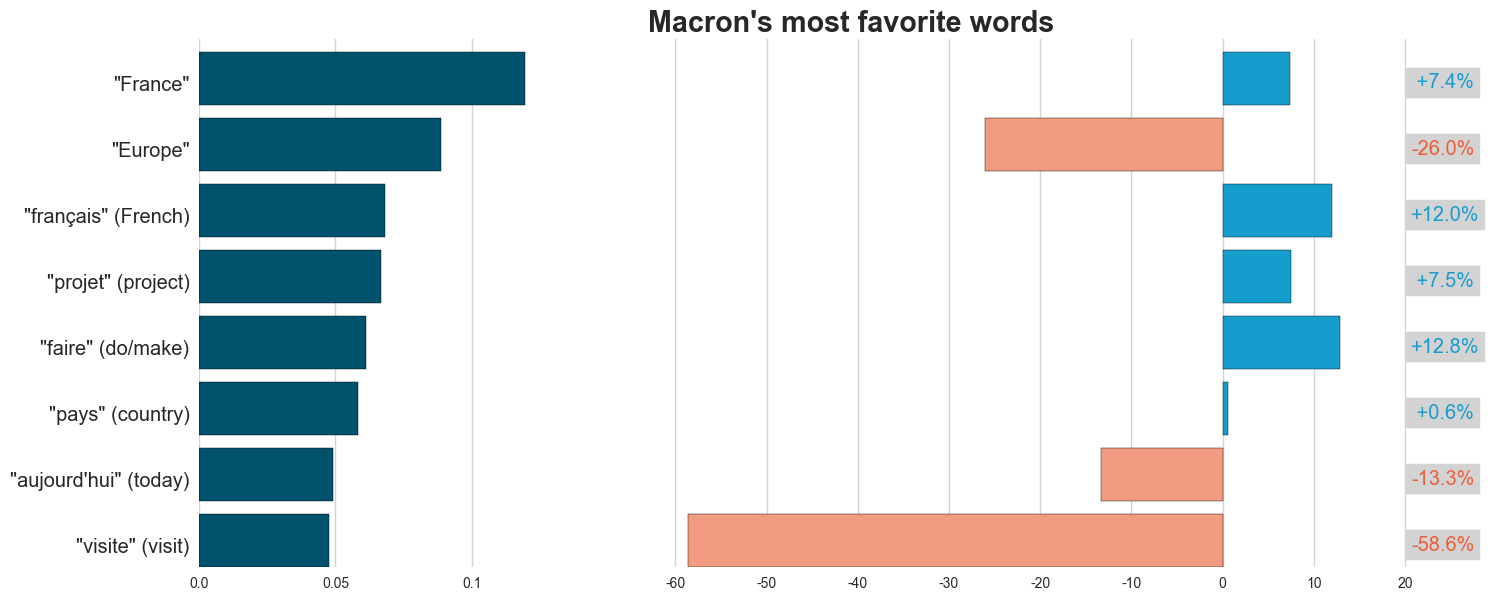

In [1518]:
dff1 = find_pop_words(word_twitt_count['mc'].sort_values()[::-1],df_full_nort,8)
plot_pop_words(word_twitt_count['mc'].sort_values()[::-1],dff1,"Macron's most favorite words","macron_words.png")

376.403714565


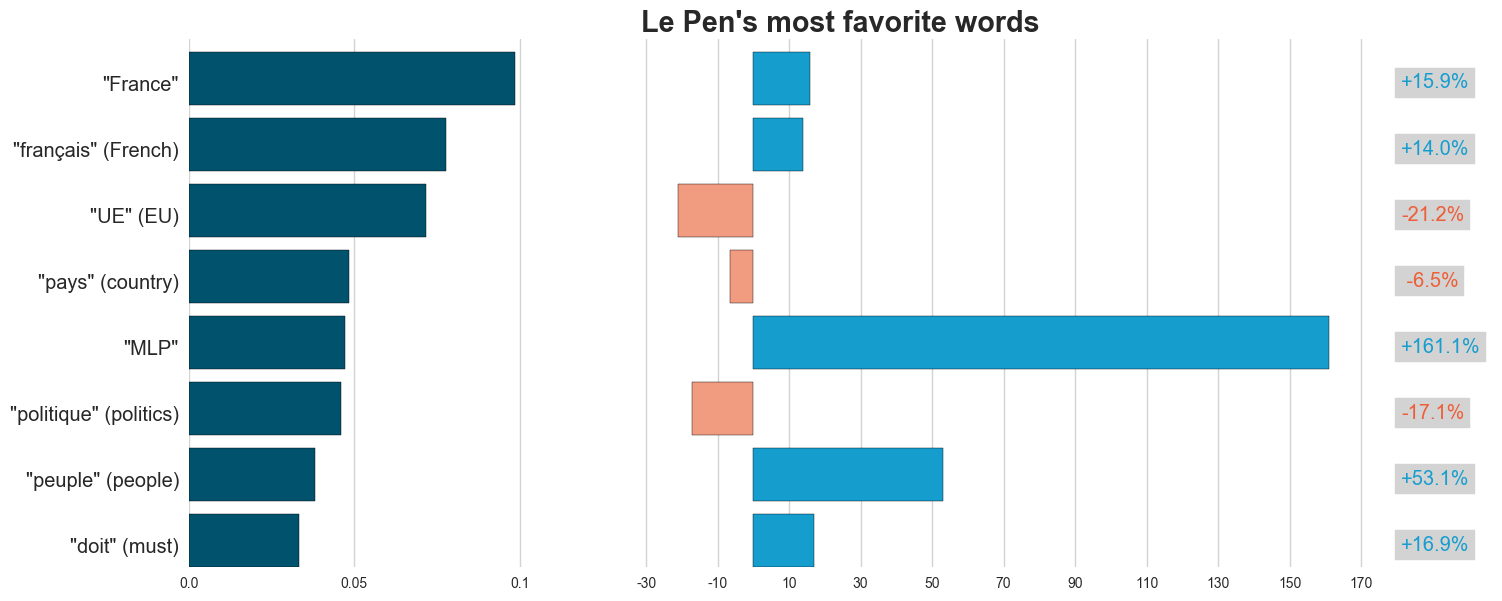

In [1519]:
dff1 = find_pop_words(word_twitt_count['lp'].sort_values()[::-1],df_lp_nort,8)
plot_pop_words(word_twitt_count['lp'].sort_values()[::-1],dff1,"Le Pen's most favorite words","lepen_words.png")

In [1000]:
df_test=df_full_nort.iloc[random.sample(range(len(df_full_nort)),len(df_full_nort)*3/4)]
word_twitt_count['mc_test']=make_dictionary(df_test)

/Users/grisha.oryol/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


281.278254649


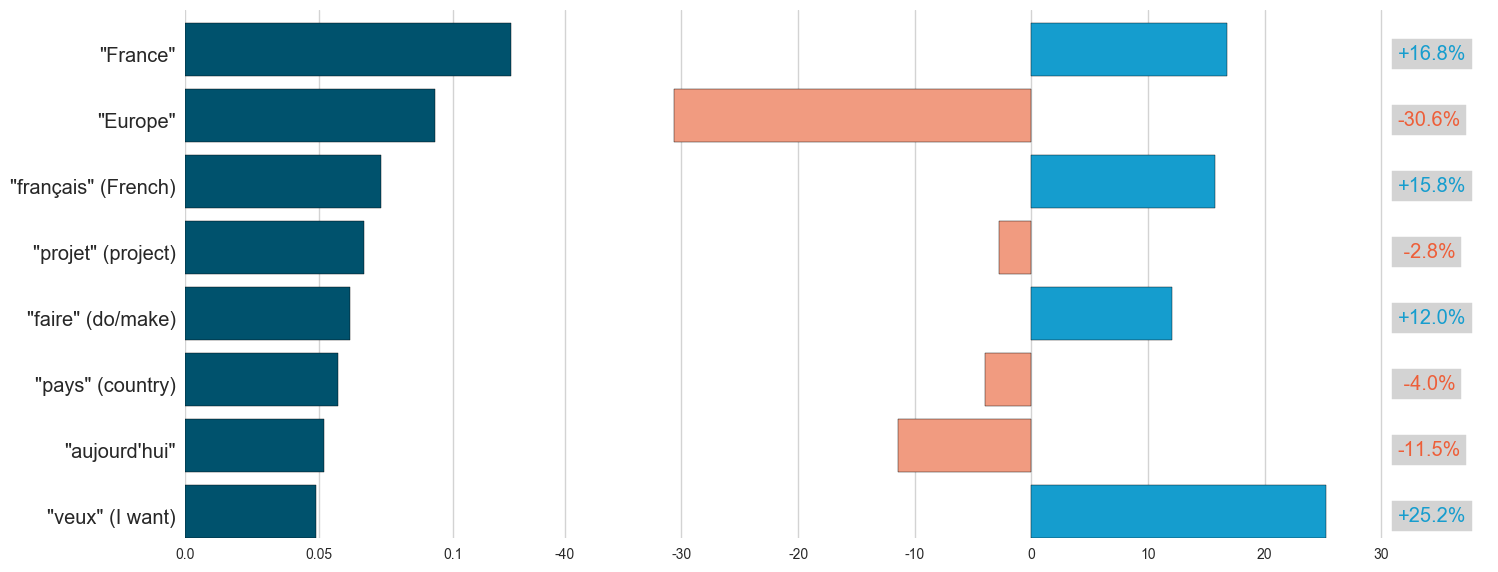

In [1001]:
dff1 = find_pop_words(word_twitt_count['mc_test'].sort_values()[::-1],df_test,8)
plot_pop_words(word_twitt_count['mc_test'].sort_values()[::-1],dff1)

## About hashtags

In [260]:
hs=pd.Series([x['text'] for x in sum(df.hashtags,[])])
(hs.value_counts()/sum(hs.value_counts()))[:10]

EnMarche            0.053352
ProgrammeEM         0.053352
LaFranceEnMarche    0.034200
MacronLille         0.030096
enmarchebordeaux    0.027360
RTLMatin            0.027360
MacronCaen          0.027360
ReformistsEU        0.027360
Macron              0.025992
MacronToulon        0.024624
dtype: float64

In [1360]:
hs=pd.Series([x['text'] for x in sum(df_lp.hashtags,[])])
(hs.value_counts()/sum(hs.value_counts())).head()

MENL            0.056956
1erMaiFN        0.052210
PlenPE          0.047167
MeetingParis    0.037378
MLPTF1          0.027292
dtype: float64

## About retweets

In [1147]:
np.mean([not pd.isnull(x) for x in df.retweeted_status])

0.083781706379707915

In [1148]:
np.mean([not pd.isnull(x) for x in df_lp.retweeted_status])

0.052064078866296978

In [478]:
np.mean([not pd.isnull(x) for x in df_ff.retweeted_status])

0.56642923505729326

In [1271]:
rt_counter_mc=pd.Series(collections.Counter([x['user']['name'] for x in df.retweeted_status if not pd.isnull(x)])).sort_values()[::-1]
print(rt_counter_mc[:10]/sum(rt_counter))
rt_counter_lp=pd.Series(collections.Counter([x['user']['name'] for x in df_lp.retweeted_status if not pd.isnull(x)])).sort_values()[::-1]
print(rt_counter_lp[:10]/sum(rt_counter))
rt_counter=pd.Series(collections.Counter([x['user']['name'] for x in df_ff.retweeted_status if not pd.isnull(x)])).sort_values()[::-1]
print(rt_counter[:10]/sum(rt_counter))

En Marche               0.028978
LAURENCE HAIM           0.001640
Gouvernement            0.001640
Élysée                  0.001093
François Hollande       0.001093
TechCrunch              0.001093
Le JDD                  0.001093
Gary Shapiro            0.001093
Günther H. Oettinger    0.000547
Gérard Collomb          0.000547
dtype: float64
Front National       0.032805
ENL - France         0.015309
Florian Philippot    0.009295
Steeve Briois        0.007654
David Rachline       0.006561
Sophie Montel        0.003827
Marine Le Pen        0.002734
Nicolas Bay          0.001640
Ludovic de Danne     0.001093
Marion Le Pen        0.001093
dtype: float64
FILLON 2017             0.278523
Nicolas R.              0.038031
Bruno Retailleau ن      0.024609
Europe 1                0.022371
Adeline ن               0.018456
Valérie Boyer ن         0.017338
Avec François Fillon    0.016219
Dolé Véronique          0.013982
Clément Coنlon ☨        0.011745
Jeunes avec Fillon      0.011186
dtype: flo

In [1520]:
def plot_pop_retweets(rt_counter_lp,n,title,file_name):
    fig=plt.figure(figsize=(5,3))
    ax=plt.subplot(222,axisbg='w')
    ax.barh(range(n),rt_counter_lp[:n][::-1],color=color_dark_teal)
    ax.set_yticks(np.arange(n)+0.4)
    ax.set_yticklabels(rt_counter_lp[:n][::-1].index,fontsize='large')
    ax.set_xticks([])
    ax.set_xlim((0,0.8*max(rt_counter_lp[:n][::-1])))
    for i in range(n):
        t=plt.text(0.25,i+0.3,"{}".format(rt_counter_lp[:n][::-1][i]),fontsize='large',
                   color='w')
    
    #ax.set_xticks(list(-offset+1000*mx*(left_grid/100.0)*left_width)+list(grid*(right_width/max_diff)))
    #ax.set_xticklabels(list(left_grid*0.1)+[int(x) for x in grid])
    #ax.yaxis.set_ticks(rg+0.3)
    
    #ax.set_axis_background('w')
    #ax.yaxis.grid(False)
    #ax.xaxis.grid(color='lightgray')
    ax.set_title(title,fontweight='bold',fontsize='xx-large')
    #plt.axvline(-offset+left_width+dist_left*0.5,color='black')
    
    params = plt.gcf()
    plSize = params.get_size_inches()
    scaling=4
    params.set_size_inches( (plSize[0]*scaling, plSize[1]*scaling) )
    
    plt.show()
    fig.savefig(file_name,bbox_inches='tight')

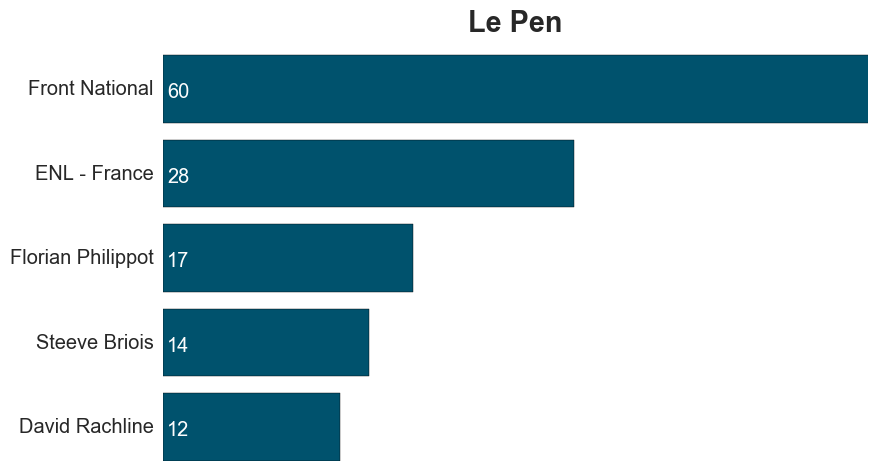

In [1523]:
plot_pop_retweets(rt_counter_lp,5,"Le Pen","lepen_top_tweets.png")

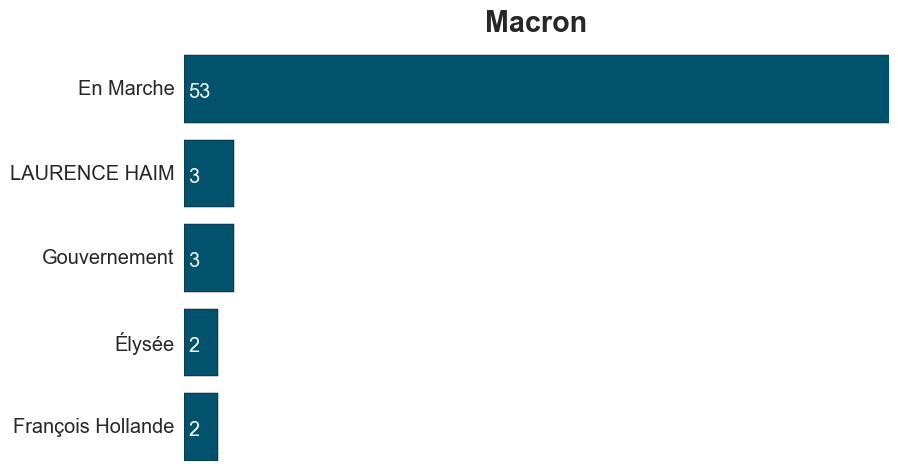

In [1522]:
plot_pop_retweets(rt_counter_mc,5,"Macron","macron_top_tweets.png")

## By Hour and day of week

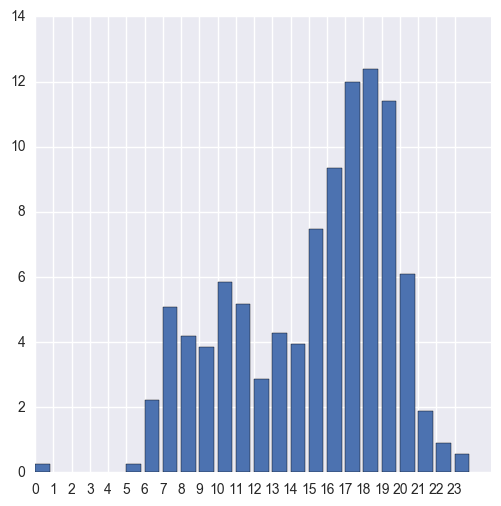

In [298]:
by_hour=df_nort.groupby('hour').created_at.count()
by_hour=by_hour/sum(by_hour)
fig=plt.figure(figsize=(20,20))
ax=plt.subplot(333)
ax.bar(by_hour.index,100*by_hour)
ax.set_xticks(range(24))
plt.show()

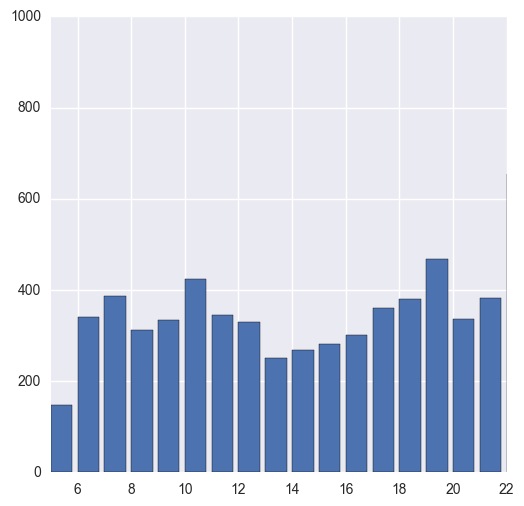

In [332]:
likes_by_hour=df_nort.groupby('hour').favorite_count.aggregate(np.mean)
fig=plt.figure(figsize=(20,20))
ax=plt.subplot(333)
ax.set_xlim((5,22))
ax.set_ylim((0,1000))
ax.bar(likes_by_hour.index,likes_by_hour)
#ax.set_xticks(range(24))

plt.show()

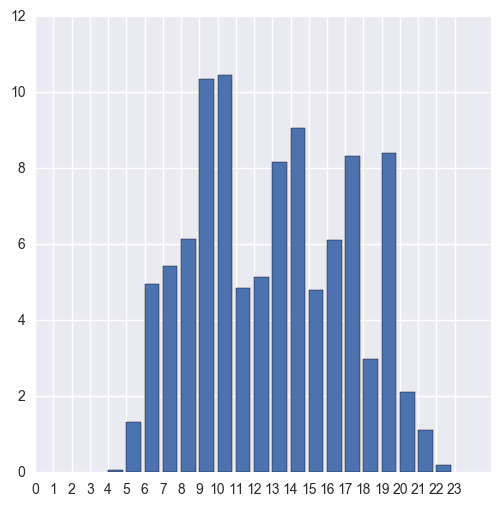

In [311]:
by_hour=df_lp_nort.groupby('hour').created_at.count()
by_hour=by_hour/sum(by_hour)
fig=plt.figure(figsize=(20,20))
ax=plt.subplot(333)
ax.bar(by_hour.index,100*by_hour)
ax.set_xticks(range(24))
plt.show()

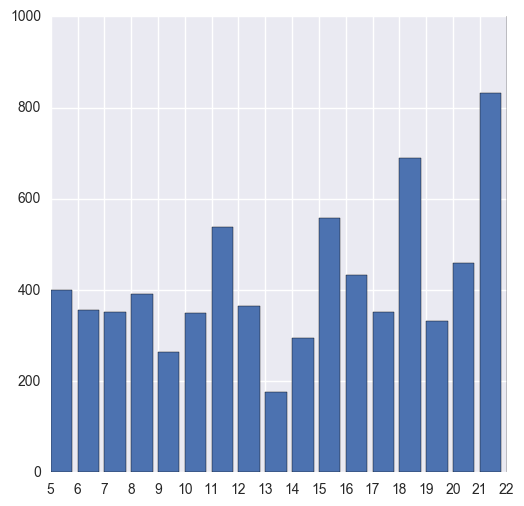

In [333]:
likes_by_hour=df_lp_nort.groupby('hour').favorite_count.aggregate(np.mean)
fig=plt.figure(figsize=(20,20))
ax=plt.subplot(333)
ax.bar(likes_by_hour.index,likes_by_hour)
ax.set_ylim((0,1000))
ax.set_xticks(range(24))
ax.set_xlim((5,22))
plt.show()

## Devices

In [1285]:
df.source.value_counts()/sum(df.source.value_counts())

<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                        0.786318
<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>        0.102998
<a href="https://dashboard.twitter.com" rel="nofollow">Twitter Business Experience</a>    0.048424
<a href="https://studio.twitter.com" rel="nofollow">Media Studio</a>                      0.034589
<a href="http://www.echofon.com/" rel="nofollow">Echofon</a>                              0.026134
<a href="http://tapbots.com/tweetbot" rel="nofollow">Tweetbot for iΟS</a>                 0.001537
Name: source, dtype: float64

In [1284]:
df_lp.source.value_counts()/sum(df_lp.source.value_counts())

<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                      0.674368
<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>      0.263709
<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>    0.028651
<a href="https://studio.twitter.com" rel="nofollow">Media Studio</a>                    0.019717
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>     0.008934
<a href="https://ads.twitter.com" rel="nofollow">Twitter Ads</a>                        0.004005
<a href="https://periscope.tv" rel="nofollow">Periscope</a>                             0.000616
Name: source, dtype: float64

In [480]:
df_ff.source.value_counts()/sum(df_lp.source.value_counts())

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>      0.477580
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                      0.402948
<a href="https://studio.twitter.com" rel="nofollow">Media Studio</a>                    0.038698
<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>    0.023342
<a href="http://snappytv.com" rel="nofollow">SnappyTV.com</a>                           0.022727
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>     0.016278
<a href="https://ads.twitter.com" rel="nofollow">Twitter Ads</a>                        0.009828
<a href="https://periscope.tv" rel="nofollow">Periscope</a>                             0.000307
Name: source, dtype: float64

## Geography

In [481]:
print(pd.Series([x['full_name'] for x in (df[~(pd.isnull(df.place))].place)]).value_counts())
print(pd.Series([x['full_name'] for x in (df_lp[~(pd.isnull(df_lp.place))].place)]).value_counts())
print(pd.Series([x['full_name'] for x in (df_ff[~(pd.isnull(df_ff.place))].place)]).value_counts())

Bordeaux, France                                25
Berlin, Germany                                 14
Bouches-du-Rhône, Provence-Alpes-Côte d'Azur    11
Bobigny, France                                  6
Boulogne, France                                 5
Toulouse, France                                 4
Paris, France                                    4
Amiens, France                                   3
Quimper, France                                  2
Metz, France                                     2
Mayenne, Pays de la Loire                        2
Guadeloupe                                       2
Hombourg-Haut, France                            2
Orly, France                                     1
Guilvinec, France                                1
Montlouis-sur-Loire, France                      1
Martinique                                       1
Deauville, France                                1
Tunisia                                          1
Rocamadour, France             